Steps

1. make audio mono and resample to 16Khz
2. normalize audio<br>
    => save as numpy arrays in an interim folder.m

* use the VAD to slice the audio to a fixed duration (with a preference of data to the end)
* Save the audio data as a numpy array / wav file<br>
    `TODO`: can opensmile extract features on a wav-file? => `yes` --> you have a process_signal function!!

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import torchaudio
from tqdm.auto import tqdm
import librosa

sys.path.append("..")
from sgs_utils.path_conf import loc_data_dir, speech_data_session_dir, interim_speech_data_dir
from sgs_utils.data_filtering import get_valid_audio_mask
from sgs_utils.dataframes import groupby_consecutive

from IPython.display import Audio, display

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler, EveryNthPoint

In [4]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))
df_vad = pd.read_parquet(loc_data_dir.joinpath("df_vad.parquet"))

df_session_v = df_session[
    get_valid_audio_mask(df_session) & (df_session.wav_duration_s > 17)
]
print(f"{df_session.shape[0]} \ {df_session_v.shape[0]}")
del df_session


3257 \ 2978


In [5]:
for _, r in tqdm(df_session_v.sample(15).iterrows(), total=len(df_session_v)):
    wav_file = list(
            speech_data_session_dir.glob(
                f"*{r.ID}/{r.DB}/{r.pic_name}*{r.time_str}*.wav"
            )
      )[0]
    vad_mask = (df_vad.ID == r.ID) & (df_vad.time_str == r.time_str)
    df_vad_rec = df_vad[vad_mask].reset_index().copy()
    
    break


  0%|          | 0/2978 [00:00<?, ?it/s]

In [6]:
df_vad_rec['voiced'] = (df_vad_rec['voice_proba'] > .95)
gc = groupby_consecutive(df_vad_rec.set_index('time_s'), col_name='voiced')

In [7]:
arr, fs = torchaudio.load(wav_file, channels_first=True, normalize=True)

arr_ = arr.numpy().ravel()

f"{arr_.shape[0]:,}"

'3,772,416'

Dash app running on http://127.0.0.1:9063/


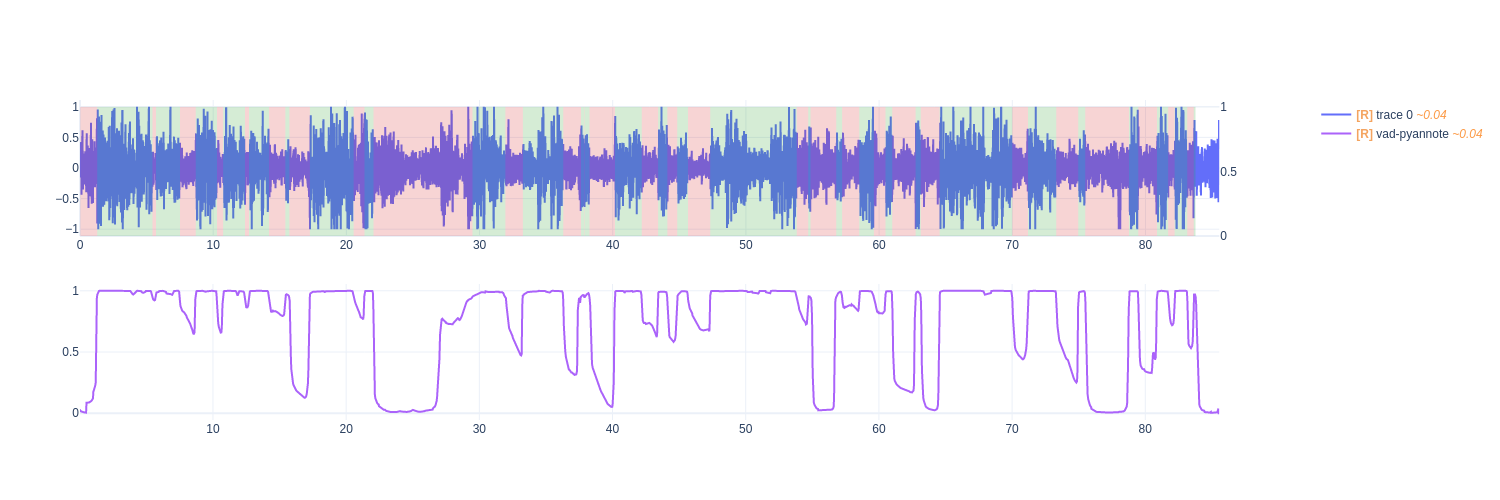

In [8]:
fig = FigureResampler(
    make_subplots(
        rows=2, cols=1, 
        specs = [[{'secondary_y': True}],
        [{}]],
        # specs=np.reshape([{"secondary_y": True}, {}], (-1, 1))
    ),
    default_n_shown_samples=2000,
)

fig.add_trace({}, hf_x=np.arange(len(arr_)) / fs, hf_y=arr_)

gc["voiced_i"] = gc["voiced"].map(int)
gc["unvoiced_i"] = (~gc["voiced"]).map(int)
# print(df_grouped)
for sqi_col, col_or in [
    ("voiced_i", "#2ca02c"),
    ("unvoiced_i", "#d62728"),
]:
    fig.add_trace(
        go.Scattergl(
            x=gc["start"],
            y=gc[sqi_col],
            mode="lines",
            line_width=0,
            fill="tozeroy",
            fillcolor=col_or,
            opacity=0.1 if "good" in sqi_col else 0.2,
            line_shape="hv",
            name=sqi_col,
            showlegend=False,
        ),
        downsampler=EveryNthPoint(interleave_gaps=False),
        max_n_samples=len(gc),
        limit_to_view=True,
        secondary_y=True,
    )

fig.add_trace(
    dict(name="vad-pyannote"),
    hf_x=df_vad_rec.time_s,
    hf_y=df_vad_rec.voice_proba,
    row=2,
    col=1,
)

fig.update_layout(template='plotly_white')
fig.show_dash(mode="external", port=9063)
fig.show(renderer='png', width=1500)

In [3]:
# Audio(arr_, rate=fs, autoplay=True)